# SED comparison pre- and post-August 2021:
 * Flux points from dataset _after August 2021_
    * 70% efficiency in gammaness and theta selection cuts
    * Intensity > 50 p.e.
 * Best-fit model for dataset _after August 2021_
    * 70% efficiency in gammaness and theta selection cuts
    * Intensity > 50 p.e.
 * Band from best-fit models taking into account several efficiencies in selection cuts for dataset _after August 2021_
    * Grid of selection cut efficiencies: 40-90% in gammaness and 70-90% in theta
    * Intensity > 50 p.e.
 * Best-fit model for dataset _before August 2021_
    * 70% efficiency in gammaness and theta selection cuts
    * Intensity > 80 p.e.

In [1]:
%matplotlib inline

import itertools
import pickle
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from gammapy.estimators import FluxPoints
from gammapy.modeling.models import create_crab_spectral_model, SkyModel

In [2]:
# Set plot style
style.use("seaborn-colorblind")

sns.set_color_codes("colorblind")
sns.set_palette("colorblind")

MPL_LINEWIDTH = 1.6

mpl_rc = {
    "figure.autolayout": False,
    "font.size": 24,
    "figure.dpi": 300,
    "lines.linewidth": 2.7,
    "axes.grid": False,
    "axes.linewidth": MPL_LINEWIDTH,
    "xtick.major.size": 8,
    "xtick.major.width": MPL_LINEWIDTH,
    "xtick.minor.size": 5,
    "xtick.minor.width": MPL_LINEWIDTH,
    "xtick.minor.visible": False,
    "ytick.major.size": 8,
    "ytick.major.width": MPL_LINEWIDTH,
    "ytick.minor.size": 5,
    "ytick.minor.width": MPL_LINEWIDTH,
    "ytick.minor.visible": True,
}
plt.style.use(mpl_rc)

In [3]:
def set_axes(axis):
    """Set axes limits and labels"""
    axis.set_xlim(4e-2, 4e1)
    axis.set_ylim(1e-12, 3e-10)

    axis.set_xlabel(r"$E\,\,[{\rm TeV}]$")
    axis.set_ylabel(
        r"$E^2 \frac{{\rm d}\phi}{{\rm d} E}\, [{\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1}]$"
    )

In [4]:
# Input files
BASE_PATH = Path("data")
src_indep_data = BASE_PATH / "src_indep"
comparison_data = src_indep_data / "comparison_sed_pre_post_August2021"

# Create directory for output plots
src_indep_plots = Path("src_indep_plots")
src_indep_plots.mkdir(exist_ok=True, parents=True)

In [5]:
def get_flux_points(min_intensity, gh_eff, th_eff, runs):
    """Get SED FluxPoints for a given data set"""
    model_file = (
        comparison_data
        / f"intensity{min_intensity}"
        / f"model_stacked_5bin_{runs}_gh_eff_{gh_eff}_th_cont_{th_eff}.dat"
    )
    flux_points_file = (
        comparison_data
        / f"intensity{min_intensity}"
        / f"sed_flux_points_5bin_{runs}_gh_eff_{gh_eff}_th_cont_{th_eff}.fits"
    )
    # Open files
    with open(model_file, "rb") as flux_model:
        model_dict = pickle.load(flux_model)

    return FluxPoints.read(
        flux_points_file,
        hdu="SED",
        format="gadf-sed",
        reference_model=SkyModel.from_dict(model_dict),
    )

In [6]:
def get_spectral_model(min_intensity, gh_eff, th_eff, runs):
    """Get SkyModel from a given spectrel model dict"""
    model_file = (
        comparison_data
        / f"intensity{min_intensity}"
        / f"model_stacked_5bin_{runs}_gh_eff_{gh_eff}_th_cont_{th_eff}.dat"
    )
    # Open model file and create sky model object
    with open(model_file, "rb") as flux_model:
        model_dict = pickle.load(flux_model)
        model = SkyModel.from_dict(model_dict)

    return model

In [7]:
sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [0.05, 30] * u.TeV,
    "yunits": u.Unit("erg cm-2 s-1"),
}


def plot_magic_ref(axis):
    """Plot reference spectrum from MAGIC (Aleksić et al. 2015)"""
    create_crab_spectral_model("magic_lp").plot(
        **sed_kwargs,
        label="MAGIC (Aleksić et al. 2015)",
        linestyle="dashed",
        color="r",
        ax=axis,
        zorder=9,
    )

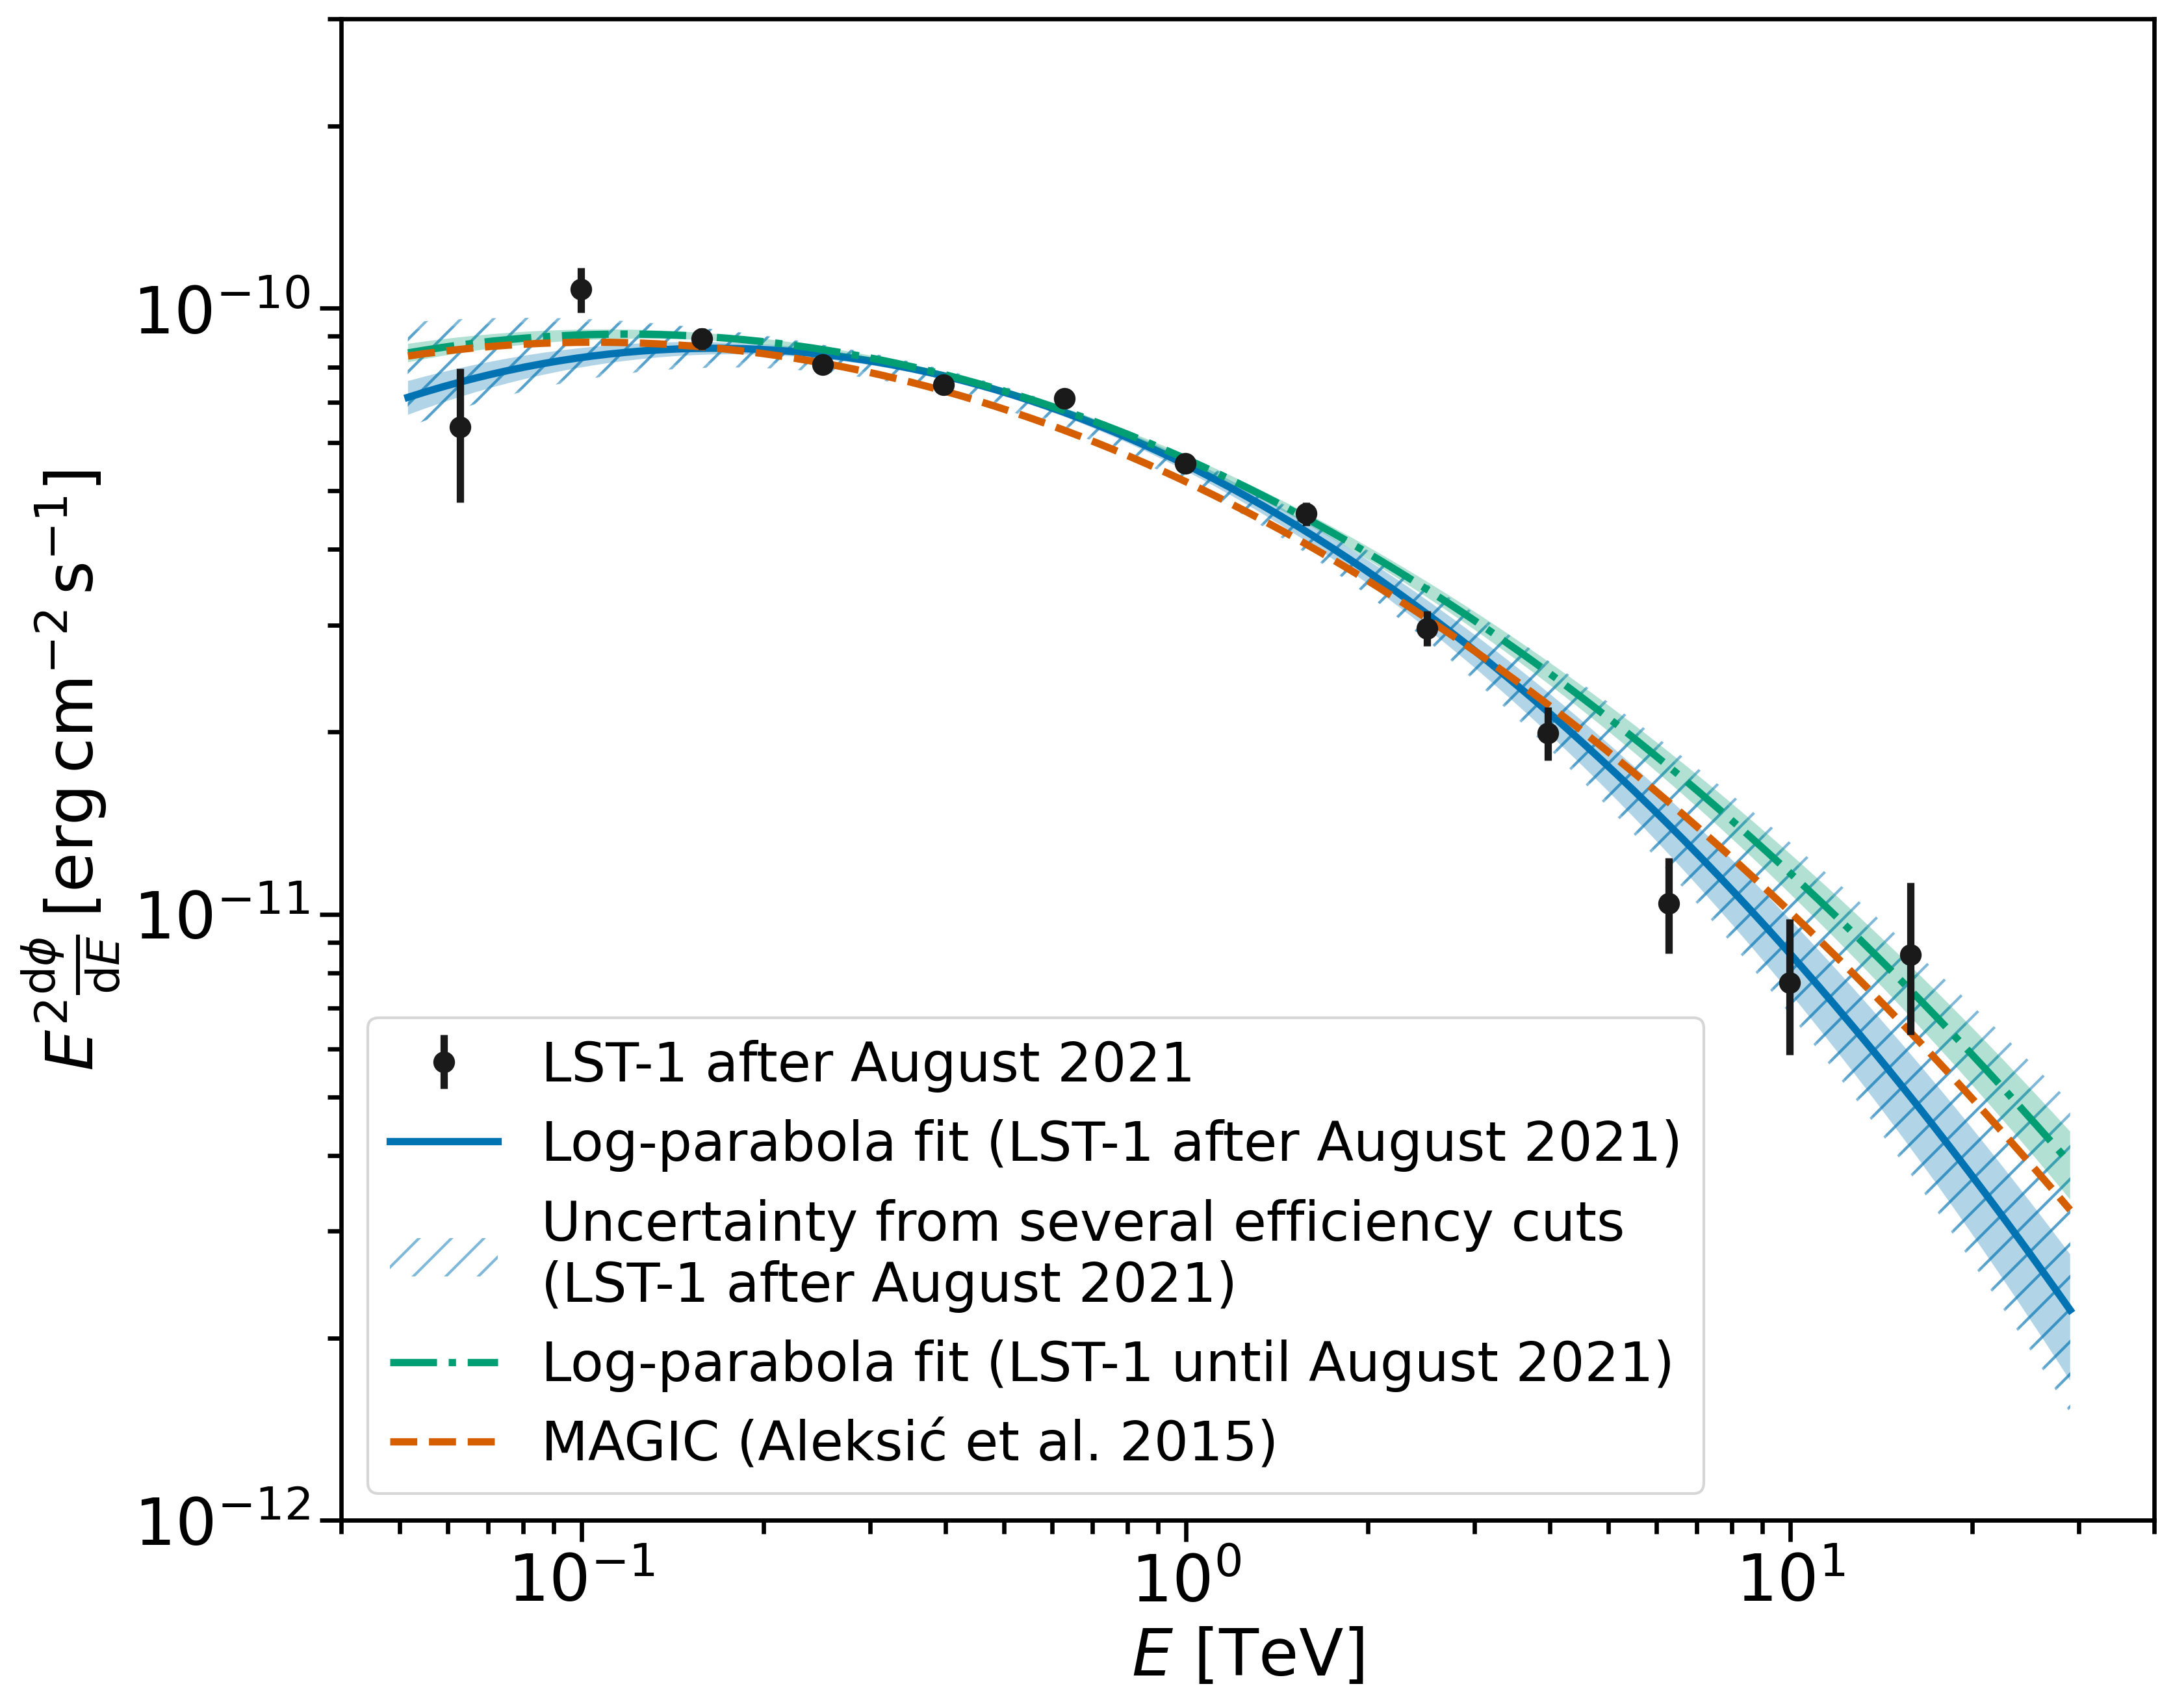

In [8]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot MAGIC Crab ref
plot_magic_ref(ax)

###############################
# Pre-August 2021
# intensity > 80 p.e.
# Runs: 2914 to 4087
###############################

# Band corresponding to 70% efficiency.

model = get_spectral_model(
    min_intensity=80, gh_eff=0.7, th_eff=0.7, runs="r2914_to_r4087"
)

model.spectral_model.plot(
    label="Log-parabola fit (LST-1 until August 2021)",
    color="g",
    linestyle="dashdot",
    alpha=1,
    zorder=8,
    **sed_kwargs,
)
model.spectral_model.plot_error(
    facecolor="g", alpha=0.3, zorder=7, **sed_kwargs
)

############################
# Post-August 2021
# intensity > 50 p.e.
# Runs: 6045 to 7277
############################

# Plot several efficiencies hatched band (post-August 2021)
gamma_efficiencies = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
theta_efficiencies = [0.7, 0.8, 0.9]

for count, (gh_eff, th_eff) in enumerate(
    itertools.product(gamma_efficiencies, theta_efficiencies)
):
    model = get_spectral_model(
        min_intensity=50, gh_eff=gh_eff, th_eff=th_eff, runs="r6045_to_r7277"
    )

    if count == 0:
        # Add label only to first band
        model.spectral_model.plot_error(
            facecolor="w",
            edgecolor="b",
            hatch="//",
            alpha=0.5,
            label="Uncertainty from several efficiency cuts \n(LST-1 after August 2021)",
            **sed_kwargs,
        )
    else:
        model.spectral_model.plot_error(
            facecolor="w",
            edgecolor="b",
            hatch="//",
            alpha=0.5,
            **sed_kwargs,
        )

# Plot flux points (post-August 2021)
flux_points = get_flux_points(
    min_intensity=50, gh_eff=0.7, th_eff=0.7, runs="r6045_to_r7277"
)

flux_points.plot(
    sed_type="e2dnde",
    markersize=7,
    color="k",
    alpha=1,
    zorder=10,
    xerr=None,
    label="LST-1 after August 2021",
)

# Plot best fit model (post-August 2021) baseline analysis (70% efficiency in gammaness and theta cuts)
flux_points.reference_model.spectral_model.plot(
    color="b",
    alpha=1,
    label="Log-parabola fit (LST-1 after August 2021)",
    **sed_kwargs,
)
flux_points.reference_model.spectral_model.plot_error(
    facecolor="b", alpha=0.3, **sed_kwargs
)

# Reorder labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [4, 3, 2, 1, 0]

# add legend to plot
plt.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order], loc=3, fontsize=20
)

set_axes(ax)

plt.savefig(
    src_indep_plots / "comparison_SED_pre_post_August2021.png", bbox_inches="tight"
)
plt.savefig(
    src_indep_plots / "comparison_SED_pre_post_August2021.pdf", bbox_inches="tight"
)